In [324]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set(style="whitegrid")
# lineer regresyon icin
from sklearn import linear_model
import statsmodels.api as sm
# polynomial features icin
from sklearn.preprocessing import PolynomialFeatures
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# tahmin performansi icin
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# regularizasyon icin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# path ile calismak icin
import sys
# dosyanin bulundugu dizini path e ekledik
mylib = '/home/admin1/datascience/datascience/library'
if mylib not in sys.path:
    sys.path.insert(1, mylib)
# parser i kullanabilmek icin
from data_description_parser import data_description_house_prices
data_dict = data_description_house_prices()

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}

# temiz veri setini dataframe icerisine yukle
house_prices = pd.read_csv('data/house_prices_clean.csv',index_col='Id')

# object tipinde olanlar numerik olmayan degiskenler listesine ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olanlar numerik degiskenler listesine ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

quantitative.remove('SalePrice')

all_vars = qualitative + quantitative

# surekli ve kategorik  degiskenler ayrildi
cont_vars = [var for var in all_vars if house_prices[var].nunique()>25]
catg_vars = [var for var in all_vars if house_prices[var].nunique()<=25]


## ***Yuksek korelasyonlu degiskenlerden outlier temizligi***

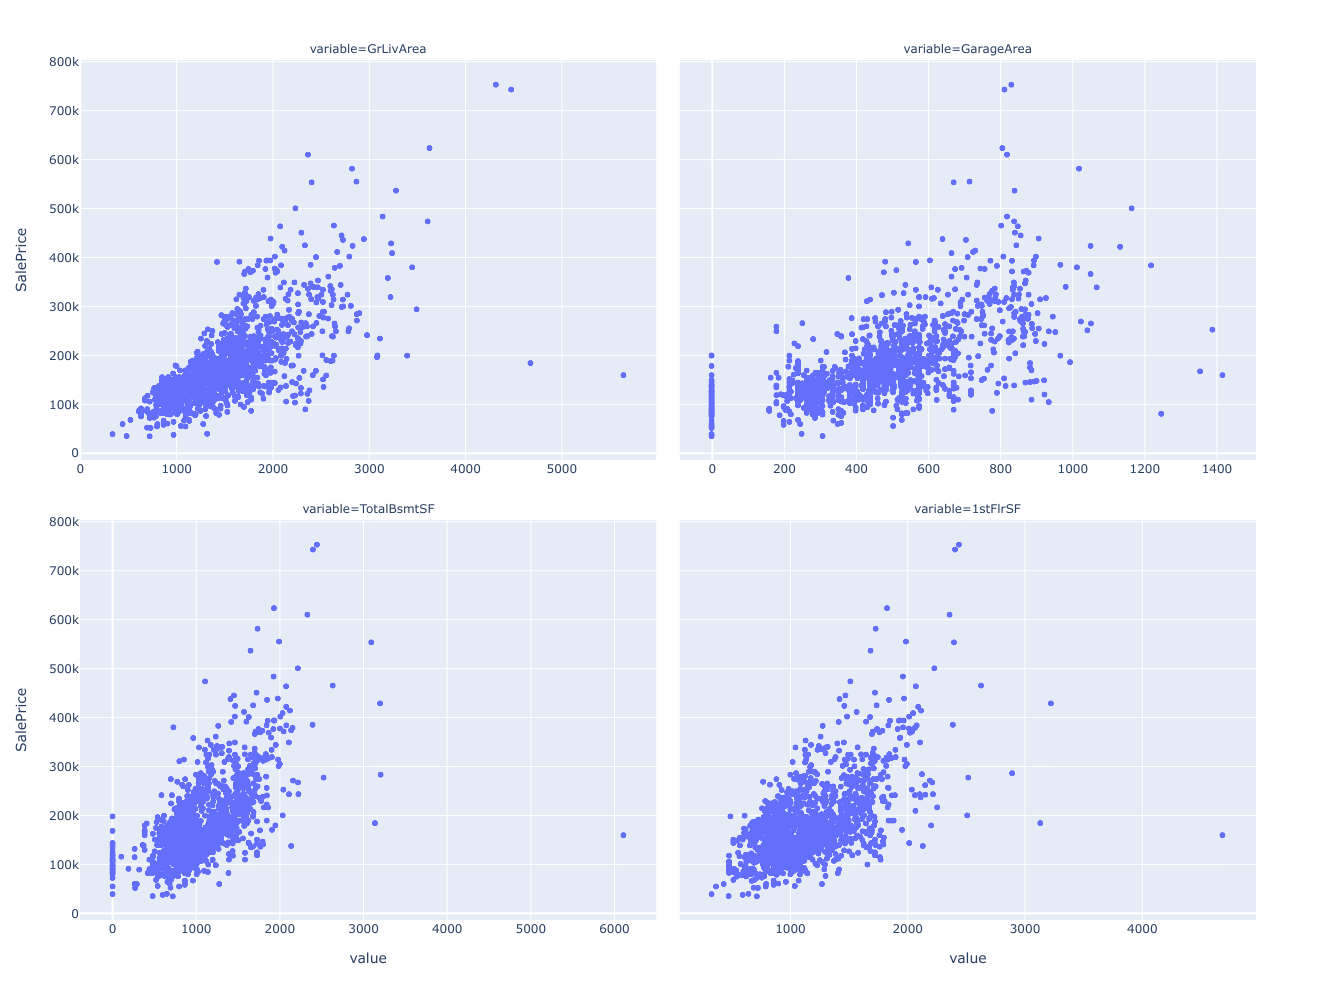

In [325]:
# yuksek korelasyonlu surekli degiskenler 
# eda da encode edilen numerik olmayanlar da dahil
high_corr_cont = ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF'  ]
high_corr_cat = ['OverallQual', 'GarageCars', 'FullBath', 
                 'Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual',
                 'GarageFinish', 'FireplaceQu', 'Foundation' ]


# surekli degiskenler icin scatterplot grafigi
f = pd.melt(house_prices, id_vars=['SalePrice'], value_vars=high_corr_cont)
#g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=6)
#g = g.map(sns.scatterplot, "value", "SalePrice")
fig = px.scatter(f, x="value", y="SalePrice",  facet_col="variable", facet_col_wrap=2)
fig.update_layout(width=1300, height=1000)
# x axis ini paylasmama ve tick label gosterimi icin
fig.update_xaxes(matches=None, showticklabels=True)
#fig.update_xaxes(showticklabels=True, row=0)
fig.show()

In [326]:
# index uzerinde apply metodu calismadigindan index i ayribor sutuna aldik
house_prices['Id'] = house_prices.index

# outlier indexleri tutan liste
outlier_indexes = []
def find_index(i):
    # ayni index i bir daha eklemesin
    if i not in outlier_indexes:
        outlier_indexes.append(i)

In [327]:
# GrLivArea 4000 den yuksek olan ve SalePrice 200000 den dusuk
house_prices.loc[(house_prices['GrLivArea']>4000) &
                 (house_prices['SalePrice']<200000)]['Id'].apply(find_index)

# GrLivArea 1500 den dusuk olan ve SalePrice 380000 den yksek
house_prices.loc[(house_prices['GrLivArea']<1500) &
                 (house_prices['SalePrice']>380000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GrLivArea']<2500) &
                 (house_prices['SalePrice']>500000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GrLivArea']<2100) &
                 (house_prices['SalePrice']>430000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GrLivArea']<1700) &
                 (house_prices['SalePrice']>390000)]['Id'].apply(find_index)

#house_prices.loc[(house_prices['GrLivArea']==1795) &                 (house_prices['SalePrice']==147000)]['Id'].apply(find_index)

# GarageArea 1200 den yuksek olan ve SalePrice 300000 den dusuk
house_prices.loc[(house_prices['GarageArea']>1200) &
                 (house_prices['SalePrice']<300000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GarageArea']==0) &
                 (house_prices['SalePrice']>170000)]['Id'].apply(find_index)


# TotalBsmtSF 1200 den yuksek olan ve SalePrice 300000 den dusuk
house_prices.loc[(house_prices['TotalBsmtSF']>6000) &
                 (house_prices['SalePrice']<200000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['TotalBsmtSF']==0) &
                 (house_prices['SalePrice']>160000)]['Id'].apply(find_index)


# 1stFlrSF 1200 den yuksek olan ve SalePrice 300000 den dusuk
house_prices.loc[(house_prices['1stFlrSF']>3000) &
                 (house_prices['SalePrice']<200000)]['Id'].apply(find_index)
len(outlier_indexes)

17

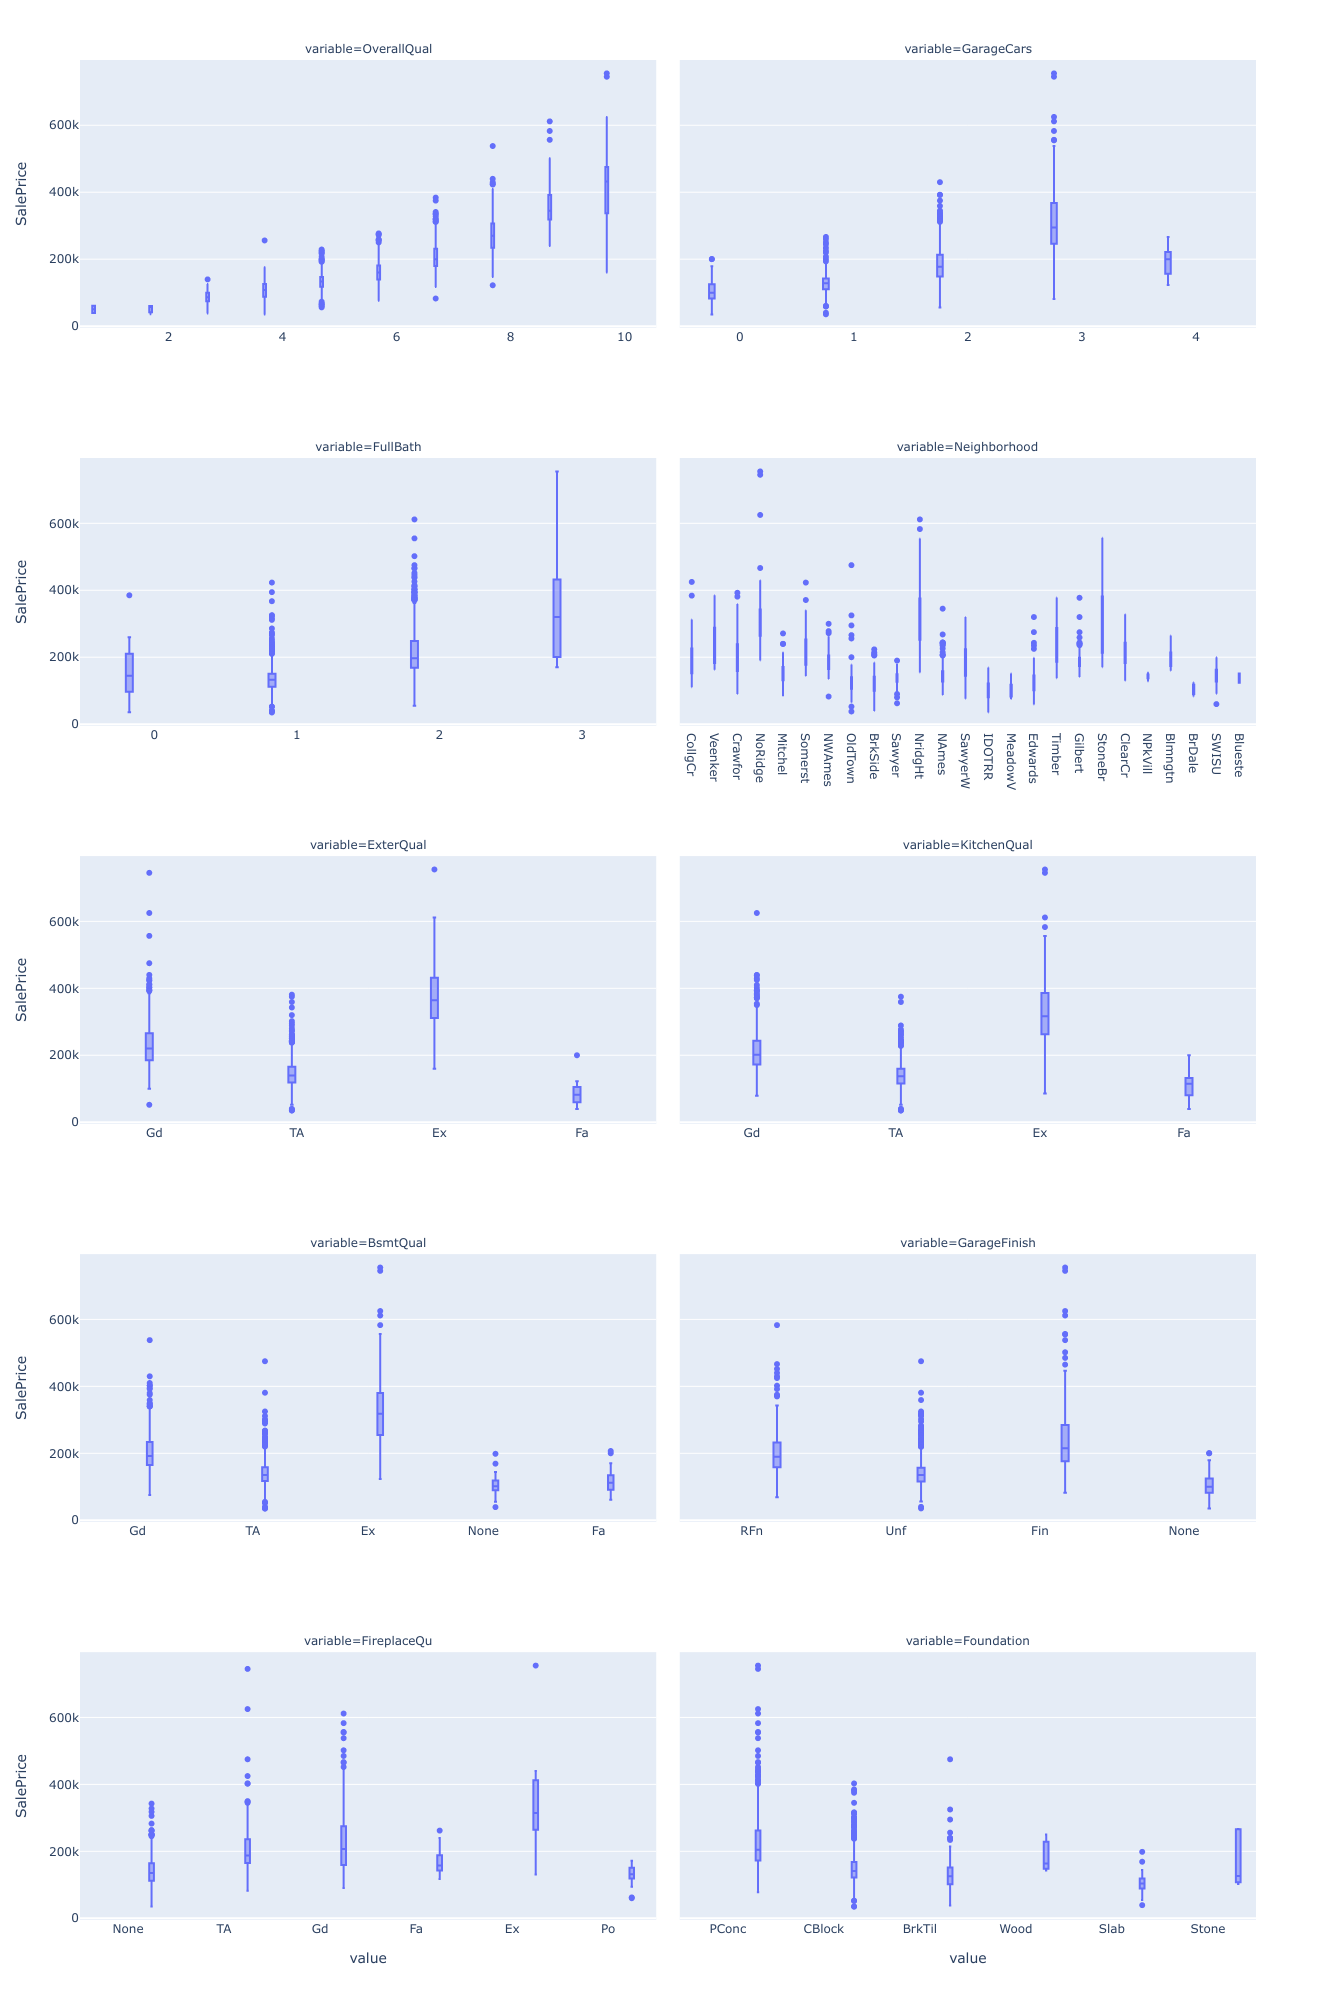

In [328]:
# kategorik degiskenler icin stripplot grafigi
f = pd.melt(house_prices, id_vars=['SalePrice'], value_vars=high_corr_cat)
#g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False, size=3.5)
#g = g.map(px.box, f, "value", "SalePrice")

fig = px.box(f, x="value", y="SalePrice",  facet_col="variable", facet_col_wrap=2)
fig.update_layout(width=1300, height=2000)
# x axis ini paylasmama ve tick label gosterimi icin
fig.update_xaxes(matches=None, showticklabels=True)
#fig.update_xaxes(showticklabels=True, row=0)
fig.show()

In [329]:
# OverallQual 10, SalePrice 200000 altinda
house_prices.loc[(house_prices['OverallQual']==10) &
                     (house_prices['SalePrice']<200000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['OverallQual']==9) &
                     (house_prices['SalePrice']>600000)]['Id'].apply(find_index)

# OverallQual 8, SalePrice 500000 ustunde
house_prices.loc[(house_prices['OverallQual']==8) &
                     (house_prices['SalePrice']>500000)]['Id'].apply(find_index)

# OverallQual 4, SalePrice 200000 ustunde
house_prices.loc[(house_prices['OverallQual']==4) &
                     (house_prices['SalePrice']>200000)]['Id'].apply(find_index)

len(outlier_indexes)

19

In [330]:
# GarageCars 4 olanlar
house_prices.loc[(house_prices['GarageCars']==4)]['Id'].apply(find_index)
len(outlier_indexes)

23

In [331]:
# FullBath 0, SalePrice 210000 ustunde
house_prices.loc[(house_prices['FullBath']==0) &
                 (house_prices['SalePrice']>210000)]['Id'].apply(find_index)
len(outlier_indexes)

25

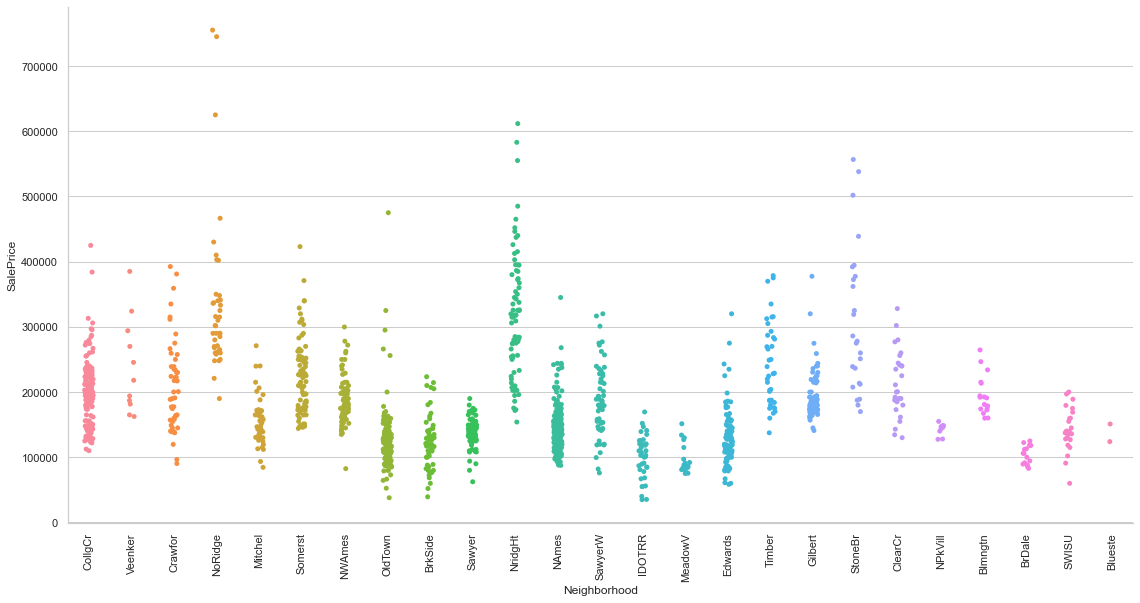

In [332]:
# Neighborhood ayri grafik cizildi
x = sns.catplot(data=house_prices, x='Neighborhood', y='SalePrice', 
                height=8, aspect=2, kind='strip')

plt.xticks(rotation=90)
plt.show()

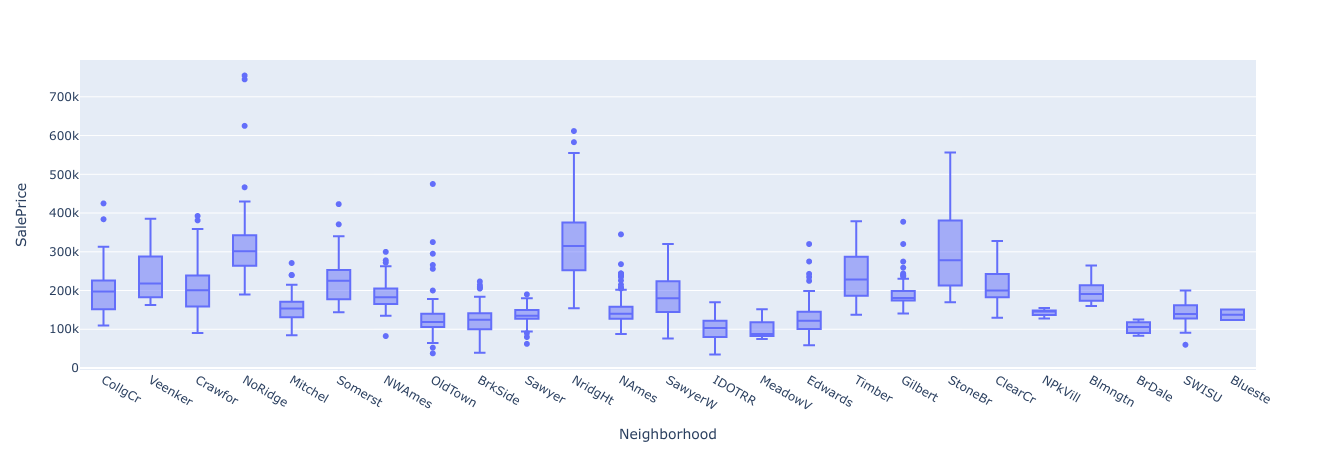

In [333]:
fig = px.box(house_prices, x='Neighborhood',  y="SalePrice")
fig.show()

In [334]:
# Neighborhood CollgCr, SalePrice 350000 ustunde
house_prices.loc[(house_prices['Neighborhood']=='CollgCr') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='NoRidge') &
                 (house_prices['SalePrice']>500000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='Somerst') &
                 (house_prices['SalePrice']>400000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='NWAmes') &
                 (house_prices['SalePrice']<100000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='OldTown') &
                 (house_prices['SalePrice']>400000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='NAmes') &
                 (house_prices['SalePrice']>340000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='Edwards') &
                 (house_prices['SalePrice']>270000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='Gilbert') &
                 (house_prices['SalePrice']>300000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Neighborhood']=='SWISU') &
                 (house_prices['SalePrice']<70000)]['Id'].apply(find_index)


# ExterQual Gd, SalePrice 550000 ustunde
house_prices.loc[(house_prices['ExterQual']=='Gd') &
                 (house_prices['SalePrice']>550000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='Gd') &
                 (house_prices['SalePrice']<60000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='Ex') &
                 (house_prices['SalePrice']>750000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='Fa') &
                 (house_prices['SalePrice']>190000)]['Id'].apply(find_index)


# KitchenQual Gd, SalePrice 600000 ustunde
house_prices.loc[(house_prices['KitchenQual']=='Gd') &
                 (house_prices['SalePrice']>600000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['KitchenQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['KitchenQual']=='Ex') &
                 (house_prices['SalePrice']>730000)]['Id'].apply(find_index)


# BsmtQual Gd, SalePrice 500000 ustunde
house_prices.loc[(house_prices['BsmtQual']=='Gd') &
                 (house_prices['SalePrice']>500000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='Ex') &
                 (house_prices['SalePrice']>730000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='None') &
                 (house_prices['SalePrice']>160000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='Fa') &
                 (house_prices['SalePrice']>200000)]['Id'].apply(find_index)


# ExterQual Gd, SalePrice 550000 ustunde
house_prices.loc[(house_prices['ExterQual']=='Gd') &
                 (house_prices['SalePrice']>550000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='Gd') &
                 (house_prices['SalePrice']<60000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='Ex') &
                 (house_prices['SalePrice']>750000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['ExterQual']=='Fa') &
                 (house_prices['SalePrice']>190000)]['Id'].apply(find_index)


# KitchenQual Gd, SalePrice 600000 ustunde
house_prices.loc[(house_prices['KitchenQual']=='Gd') &
                 (house_prices['SalePrice']>600000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['KitchenQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['KitchenQual']=='Ex') &
                 (house_prices['SalePrice']>730000)]['Id'].apply(find_index)


# BsmtQual Gd, SalePrice 500000 ustunde
house_prices.loc[(house_prices['BsmtQual']=='Gd') &
                 (house_prices['SalePrice']>500000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='TA') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='Ex') &
                 (house_prices['SalePrice']>730000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='None') &
                 (house_prices['SalePrice']>160000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['BsmtQual']=='Fa') &
                 (house_prices['SalePrice']>200000)]['Id'].apply(find_index)


# GarageFinish RFn, SalePrice 550000 ustunde
house_prices.loc[(house_prices['GarageFinish']=='RFn') &
                 (house_prices['SalePrice']>550000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GarageFinish']=='Unf') &
                 (house_prices['SalePrice']>350000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GarageFinish']=='Unf') &
                 (house_prices['SalePrice']<41000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GarageFinish']=='Fin') &
                 (house_prices['SalePrice']>700000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['GarageFinish']=='None') &
                 (house_prices['SalePrice']>199000)]['Id'].apply(find_index)


house_prices.loc[(house_prices['FireplaceQu']=='TA') &
                 (house_prices['SalePrice']>610000)]['Id'].apply(find_index)

house_prices.loc[(house_prices['Foundation']=='BrkTil') &
                 (house_prices['SalePrice']>450000)]['Id'].apply(find_index)
len(outlier_indexes)

49

- Toplam 49 gozlem veri setinden cikarilacak.

In [335]:
house_prices = house_prices.drop(index=outlier_indexes)

### ***Outlier temizliginden sonra grafikler***

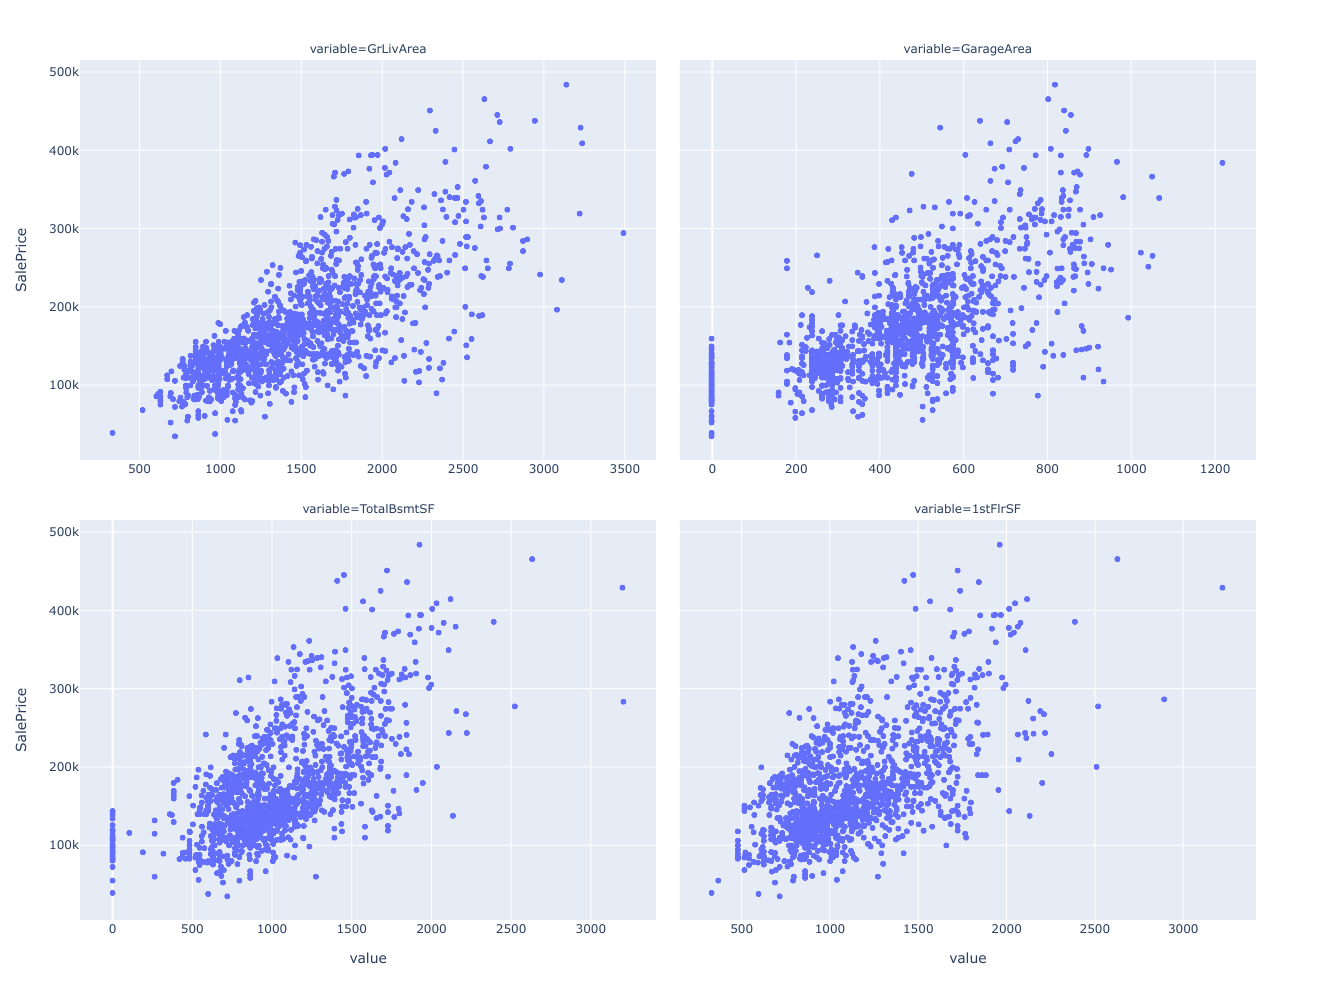

In [336]:
# surekli degiskenler icin scatterplot grafigi
f = pd.melt(house_prices, id_vars=['SalePrice'], value_vars=high_corr_cont)

fig = px.scatter(f, x="value", y="SalePrice",  facet_col="variable", facet_col_wrap=2)
fig.update_layout(width=1300, height=1000)
# x axis ini paylasmama ve tick label gosterimi icin
fig.update_xaxes(matches=None, showticklabels=True)
#fig.update_xaxes(showticklabels=True, row=0)
fig.show()

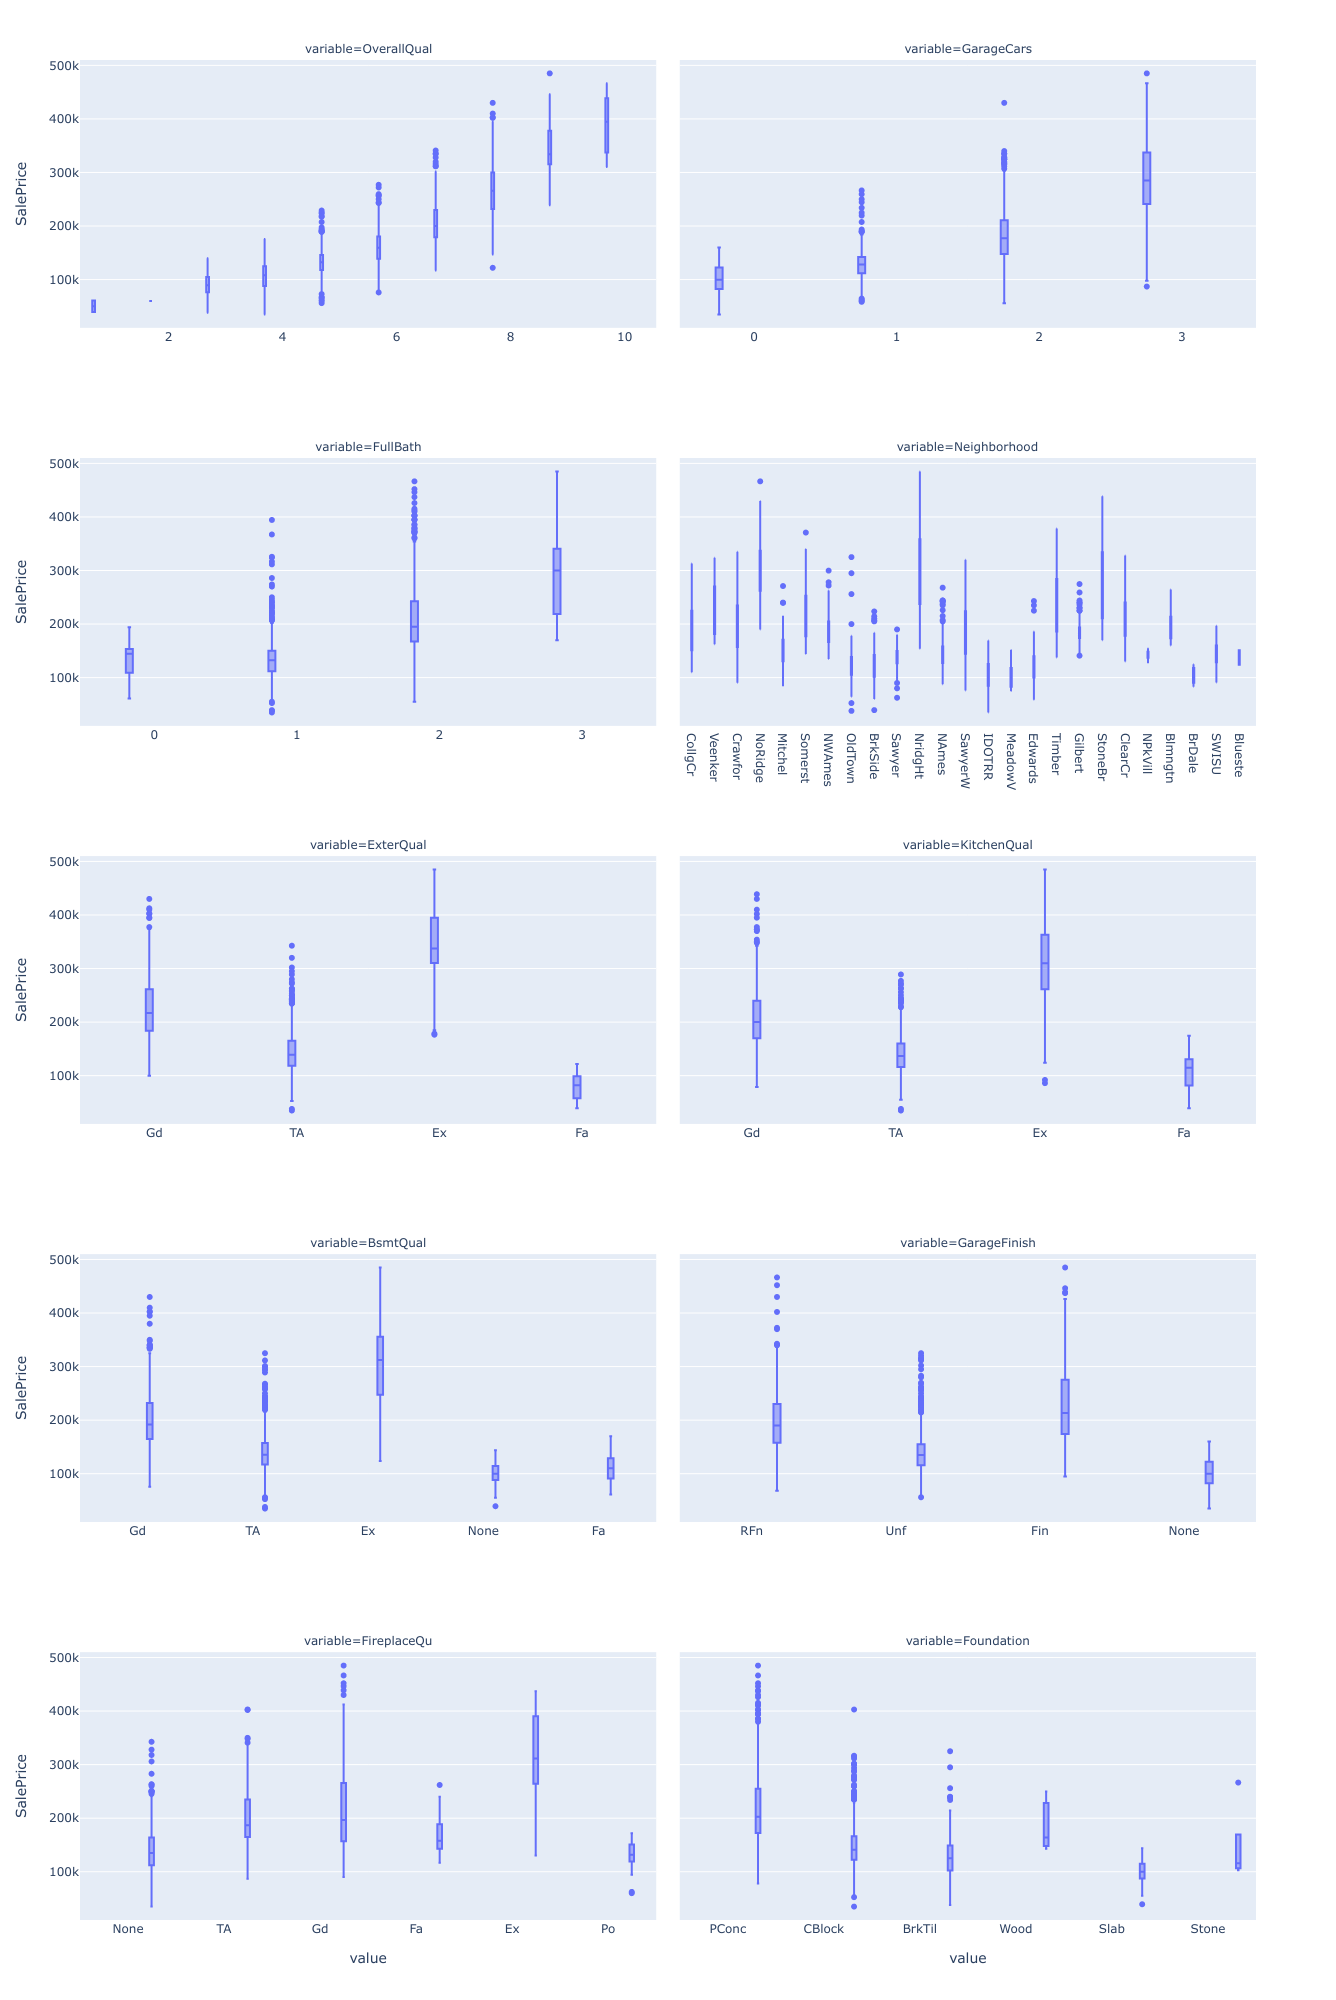

In [337]:
# kategorik degiskenler icin stripplot grafigi
f = pd.melt(house_prices, id_vars=['SalePrice'], value_vars=high_corr_cat)

fig = px.box(f, x="value", y="SalePrice",  facet_col="variable", facet_col_wrap=2)
fig.update_layout(width=1300, height=2000)
# x axis ini paylasmama ve tick label gosterimi icin
fig.update_xaxes(matches=None, showticklabels=True)
#fig.update_xaxes(showticklabels=True, row=0)
fig.show()

In [338]:
house_prices.to_csv('data/house_prices_out.csv', index=False)

In [339]:
data_dict['GrLivArea']

{'description': 'Above grade (ground) living area square feet'}